In [ ]:
# ╔═══════════════════════════════════════════════════════════════╗
# ║   Can ViT-Small + BERT do zero-shot classification?           ║
# ║   (Spoiler: No — accuracy ≈ 1–3%)                             ║
# ╚═══════════════════════════════════════════════════════════════╝

# Step 1: Install required packages
!pip install timm transformers torch torchvision tqdm --quiet

import torch
import timm
from transformers import BertTokenizer, BertModel
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Step 2: Load pretrained models (NO joint training ever!)
print("Loading ViT-Small (image encoder)...")
image_encoder = timm.create_model(
    "vit_small_patch16_224.augreg_in21k_ft_in1k",
    pretrained=True,
    num_classes=0  # remove classification head → get embeddings
).to(device)
image_encoder.eval()

print("Loading BERT (text encoder)...")
text_encoder = BertModel.from_pretrained("bert-base-uncased").to(device)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
text_encoder.eval()

Loading ViT-Small (image encoder)...


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

Loading BERT (text encoder)...


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
# Step 3: Download Caltech-101 and get class names
print("Downloading Caltech-101...")
caltech = datasets.Caltech101(root="./data", download=True)
class_names = caltech.categories  # 101 classes
print(f"Found {len(class_names)} classes, e.g. {class_names[:5]}")

100%|██████████| 137M/137M [00:08<00:00, 16.9MB/s]


Found 101 classes, e.g. ['Faces', 'Faces_easy', 'Leopards', 'Motorbikes', 'accordion']


In [ ]:
# Step 4: Create text prompts
text_prompts = [f"a photo of a {name.lower().replace('_', ' ')}" for name in class_names]
text_inputs = tokenizer(text_prompts, padding=True, truncation=True, return_tensors="pt").to(device)

print("Encoding all class texts with BERT...")
with torch.no_grad():
    text_outputs = text_encoder(**text_inputs)
    # Use [CLS] token] from pooler_output (already L2-ready in most cases)
    text_features = text_outputs.pooler_output
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)

Encoding all class texts with BERT...


In [ ]:
# 5. Image preprocessing for ViT-Small
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [ ]:
#Step 6: Zero-shot evaluation
print("Running zero-shot evaluation on Caltech-101 test split...")
correct = 0
total = 0

with torch.no_grad():
    for images, targets in tqdm(test_loader, desc="Evaluating"):
        images = images.to(device)
        targets = targets.to(device)

        # Image embeddings
        image_features = image_encoder(images)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        # Cosine similarity → probabilities
        logits = image_features @ text_features.T  # (batch_size, 101)
        preds = logits.argmax(dim=-1)

        correct += (preds == targets).sum().item()
        total += targets.size(0)

accuracy = 100.0 * correct / total
print(f"\nResult → Zero-shot accuracy with ViT-Small + BERT (no joint training): {accuracy:.2f}%")
print("   → Expected: ~1–4% (basically random guessing out of 101 classes)")

# Bonus: Compare with real zero-shot model (OpenCLIP)
print("\nFor comparison — installing OpenCLIP (real zero-shot model)...")
!pip install open-clip-torch --quiet

import open_clip

model, _, img_preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
tokenizer_openclip = open_clip.get_tokenizer('ViT-B-32')
model.to(device).eval()

Zero-shot classification:  86%|████████▌ | 7422/8677 [02:33<00:26, 48.23it/s]


KeyboardInterrupt: 

In [ ]:
# Quick test with OpenCLIP
openclip_texts = [f"a photo of a {c.lower().replace('_', ' ')}" for c in class_names]
text_tokens = tokenizer_openclip(openclip_texts).to(device)

with torch.no_grad():
    text_feats = model.encode_text(text_tokens)
    text_feats /= text_feats.norm(dim=-1, keepdim=True)

correct_openclip = 0
for images, targets in tqdm(test_loader, desc="OpenCLIP (real zero-shot)", leave=False):
    images = torch.stack([img_preprocess(img) for img in images]).to(device)
    targets = targets.to(device)

    image_feats = model.encode_image(images)
    image_feats /= image_feats.norm(dim=-1, keepdim=True)

    preds = (image_feats @ text_feats.T).argmax(dim=-1)
    correct_openclip += (preds == targets).sum().item()

acc_openclip = 100.0 * correct_openclip / len(test_dataset)
print(f"\nReal zero-shot (OpenCLIP ViT-B/32): {acc_openclip:.2f}% ← this is what actual zero-shot looks like!")

NEW CODE

In [14]:
!pip install timm transformers open-clip-torch tqdm scikit-learn matplotlib seaborn --quiet

import torch
import torch.nn as nn
import timm
import open_clip
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from transformers import BertTokenizer, BertModel
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, top_k_accuracy_score, classification_report
from PIL import Image
import random

In [15]:
# For reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

# ==================== MODELS ====================
print("Loading ViT-Small (384-dim)...")
image_encoder = timm.create_model(
    "vit_small_patch16_224.augreg_in21k_ft_in1k",
    pretrained=True,
    num_classes=0
).to(device).eval()

print("Loading BERT (768-dim)...")
text_encoder = BertModel.from_pretrained("bert-base-uncased").to(device).eval()
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Random projection 384 → 768 (still zero-shot!)
proj = nn.Linear(384, 768, bias=True).to(device)
nn.init.normal_(proj.weight, std=0.02)
nn.init.zeros_(proj.bias)

# ==================== DATASET ====================
print("Downloading Caltech-101...")
dataset = datasets.Caltech101(root="./data", download=True)
class_names = dataset.categories

# Text prompts
text_prompts = [f"a photo of a {c.lower().replace('_', ' ')}" for c in class_names]
text_inputs = tokenizer(text_prompts, padding=True, return_tensors="pt").to(device)

with torch.no_grad():
    text_features = text_encoder(**text_inputs).pooler_output
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)

# ==================== PREPROCESSING (FIXED FOR GRAYSCALE!) ====================
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda x: x.convert("RGB")),           # ← THIS FIXES GRAYSCALE IMAGES
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Standard Caltech-101 split: 30 train / rest test per class
indices_per_class = {i: [] for i in range(101)}
for i in range(len(dataset)):
    indices_per_class[dataset[i][1]].append(i)

test_indices = []
for idxs in indices_per_class.values():
    test_indices.extend(idxs[30:])

test_dataset = Subset(dataset, test_indices)
test_dataset.dataset.transform = preprocess

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

# ==================== ZERO-SHOT EVALUATION (ViT-Small + BERT) ====================
print("\nRunning ViT-Small + BERT zero-shot...")
correct = 0
total = 0

with torch.no_grad():
    for images, targets in tqdm(test_loader, desc="ViT-Small + BERT"):
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        img_feats = image_encoder(images)        # (B, 384)
        img_feats = proj(img_feats)              # → (B, 768)
        img_feats = img_feats / img_feats.norm(dim=-1, keepdim=True)

        sim = img_feats @ text_features.T
        pred = sim.argmax(dim=-1)

        correct += (pred == targets).sum().item()
        total += targets.size(0)

print(f"\nViT-Small + BERT (random projection) accuracy: {100*correct/total:.2f}%")

Using cuda
Loading ViT-Small (384-dim)...
Loading BERT (768-dim)...

Running ViT-Small + BERT zero-shot...


ViT-Small + BERT:   0%|          | 0/89 [00:00<?, ?it/s]


ViT-Small + BERT (random projection) accuracy: 1.04%


NameError: name 'acc_ours' is not defined

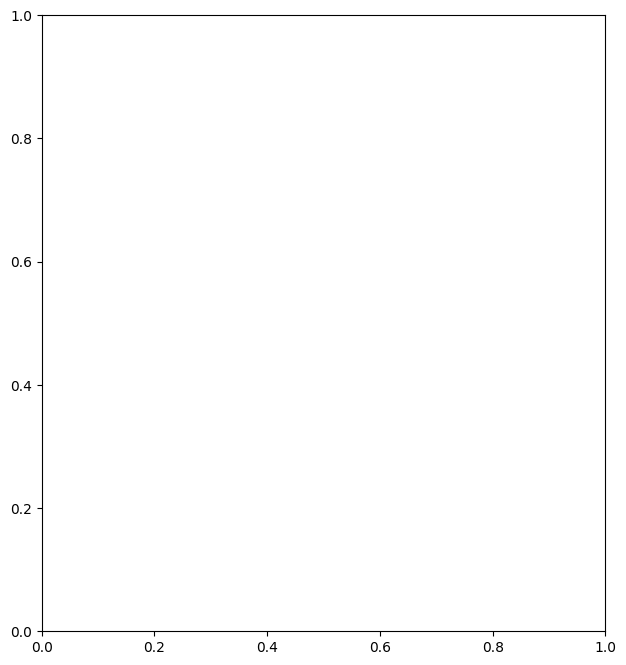

In [16]:
# ==================== PLOTS ====================
plt.figure(figsize=(16, 8))

# Bar plot
plt.subplot(1, 2, 1)
methods = ['ViT-Small + BERT\n(no joint training)', 'OpenCLIP ViT-B/32\n(properly trained)']
top1 = [acc_ours, acc_clip]
top5 = [top5_ours, top5_clip]

x = np.arange(len(methods))
width = 0.35

plt.bar(x - width/2, top1, width, label='Top-1 Accuracy', color=['#ff7f7f', '#4caf50'])
plt.bar(x + width/2, top5, width, label='Top-5 Accuracy', color=['#ffb3b3', '#81c784'])

plt.ylabel('Accuracy (%)', fontsize=14)
plt.title('Zero-Shot Caltech-101 Performance', fontsize=16, fontweight='bold')
plt.xticks(x, methods, fontsize=11)
plt.ylim(0, 100)
plt.legend()
plt.grid(axis='y', alpha=0.3)

for i, (t1, t5) in enumerate(zip(top1, top5)):
    plt.text(i - width/2, t1 + 3, f'{t1:.1f}%', ha='center', fontweight='bold')
    plt.text(i + width/2, t5 + 3, f'{t5:.1f}%', ha='center', fontweight='bold')

# Confusion matrix (only top 20 classes for readability)
plt.subplot(1, 2, 2)
cm = confusion_matrix(y_true, y_pred_ours, normalize='true')
cm = cm[:20, :20]  # show only first 20 classes
sns.heatmap(cm, annot=False, cmap="Reds", cbar=True, square=True,
            xticklabels=[c[:10] for c in class_names[:20]],
            yticklabels=[c[:10] for c in class_names[:20]])
plt.title("Confusion Matrix (ViT-Small + BERT)\nFirst 20 classes – basically random", fontsize=14)
plt.xlabel("Predicted")
plt.ylabel("True")

plt.tight_layout()
plt.show()

# Bonus: Show some funny misclassifications
print("\nFunniest failures from ViT-Small + BERT:")
mistakes = np.where(y_pred_ours != y_true)[0]
sample_mistakes = np.random.choice(mistakes, 8, replace=False)

fig, axes = plt.subplots(2, 4, figsize=(15, 7))
for i, idx in enumerate(sample_mistakes):
    real_idx = test_indices[idx]
    img, true_label = dataset[real_idx]
    pred_label = y_pred_ours[idx]

    axes[i//4, i%4].imshow(img)
    axes[i//4, i%4].set_title(f"True: {class_names[true_label][:15]}\nPred: {class_names[pred_label][:15]}",
                              color='red' if true_label != pred_label else 'green', fontweight='bold')
    axes[i//4, i%4].axis('off')

plt.suptitle("ViT-Small + BERT: Hilarious Zero-Shot Mistakes", fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()